# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">Porto Seguro’s Safe Driver Prediction - Kaggle</p>

## Predict if a driver will file an insurance claim next year

<img src='./img/safe-driving-730x432.jpeg' style='height:400px; border-radius: 5px;'/>

---
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">Contents:</p>

* [1. Introduction](#1)
    * [1.1 Data Description](#1.1)
    * [1.2 Libraries](#1.2)
    * [1.3 Loading Dataset](#1.3)
* [2. Preprocessing & Feature Engineering](#2)
    * [2.1 SMOTE](#2.1)
    * [2.2 Cross-validation](#2.2)
    * [2.3 Feature Selection](#2.3)
* [3. Models](#3)
    * [3.1 Lightgbm](#3.1)
    * [3.2 Neural Networks](#3.2)
* [4. Evaluation](#4)
* [5. Kaggle Submission](#5)

<a id="1"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">1- Introduction</p>

<img title="Porto Seguro" src="img/porto-seguro-logo-1-3.png" alt="Porto Seguro" style='height:80px; padding: 10px; padding-right: 15px;' align="center"> 

[Porto Seguro](https://www.portoseguro.com.br/en/institutional) is one of the largest insurance companies in Brazil specialized in car and home insurance. Located in São Paulo, Porto Seguro has been one of the leading insurers in Brazil since its foundation in 1945.

A key challenge faced by all major insurers is, when it comes to car insurance, how to address fairness towards good drivers and try not to penalize those who have a good driving history on account of a few bad drivers. Inaccuracies in car insurance claim predictions usually raise its cost for good drivers and reduce the price for bad ones.

Porto Seguro has been applying Machine Learning for more than 20 years and intends to make car insurance more accessible to everyone. Thinking about that, the company created an online competition to help them explore new and more powerful ML methods.

<img title="Porto Seguro" src="img/Kaggle_logo.png" alt="Porto Seguro" style='height:80px; padding: 10px; padding-right: 15px' align="center">

[Kaggle](https://www.kaggle.com/) is an online community of data scientists and allows users to find and publish data sets, explore and build ML models, and enter competitions to solve data science challenges.

In this [competition](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/), the challenge is build a model that predicts the probability that a car insurance policy holder will file a claim next year.

<a id="1.1"></a>
## Data Description

In the train and test data:

- Features that belong to similar groupings are tagged as such in the feature names (e.g., `ind`, `reg`, `car`, `calc`). 
- Feature names include the postfix `bin` to indicate binary features and `cat` to indicate categorical features.
- Features __without__ these designations are either __continuous or ordinal__.
- Values of `-1` indicate that the feature was missing from the observation. 
- The `target` columns signifies whether or not a claim was filed for that policy holder. 

- `ind` - individuals
- `reg` - regions
- `car` - cars
- `calc` - calculated features

- `_bin` - binary 
- `_cat` - categorical

<a id="1.2"></a>
## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import random

%matplotlib inline
matplotlib.style.use("ggplot")

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Preprocessing
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from lightgbm import LGBMClassifier


import time
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
from platform import python_version
print('Python version:', python_version())

Python version: 3.8.5


In [3]:
# !pip install -q -U watermark
%reload_ext watermark
%watermark -a "Leandro Pessini" --iversions

Author: Leandro Pessini

matplotlib: 3.3.2
numpy     : 1.19.2
seaborn   : 0.11.1
pandas    : 1.1.3
plotly    : 4.14.3
lightgbm  : 3.1.1
sklearn   : 0.23.2



<a id="1.3"></a>
## Loading Dataset

In [4]:
# Kaggle
#kaggle_path = "../input/porto-seguro-safe-driver-prediction/"

# Local
local_path = "./data/"

In [5]:
train_df = pd.read_csv(local_path + "train.csv").set_index('id')
test_df = pd.read_csv(local_path + "test.csv").set_index('id')

---
As per description, there are a few variables called calculated features. In one of the discussions, it was highlighted that some kind of transformation was applied in order to generate these features. I will drop these features and apply the transformations on my best judgment.

In [6]:
train_df = train_df.drop(train_df.filter(regex='_calc').columns, axis=1)
test_df = test_df.drop(test_df.filter(regex='_calc').columns, axis=1)

In [7]:
print('Train Dataset - Number of rows are',train_df.shape[0], 'and number of columns are ',train_df.shape[1])
print('Test Dataset - Number of rows are',test_df.shape[0], 'and number of columns are ',test_df.shape[1])

Train Dataset - Number of rows are 595212 and number of columns are  38
Test Dataset - Number of rows are 892816 and number of columns are  37


<a id="2"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">2- Preprocessing & Feature Engineering</p>

## Imbalanced data

`target` variable 1 means that a claim was filed and 0 that it was not claimed.

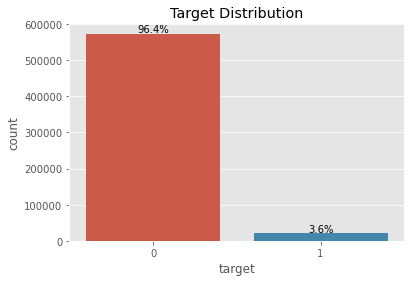

In [8]:
y = train_df.target
ax = sns.countplot(y,label="Count")

total_size = len(train_df)

# Display the target value ratio at the top of the bar
for patch in ax.patches:
    height = patch.get_height()
    width = patch.get_width()
    left_coord = patch.get_x()
    percent = height/total_size*100

    ax.text(x=left_coord + width/2.0, 
            y=height + 3000,
            s='{:1.1f}%'.format(percent),
            ha='center')

ax.set_title('Target Distribution');

## Missing values

Values of __`-1`__ indicate that the feature was missing from the observation.

In [10]:
vars_with_missing = []

for f in train_df.columns:
    missings = train_df[train_df[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train_df.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('\nIn total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values

In total, there are 13 variables with missing values


---
Only `ps_car_03_cat` and `ps_car_05_cat` have a large number of missing values.
- ps_car_03_cat has 411231 records (69.09%)
- ps_car_05_cat has 266551 records (44.78%)

__I will drop those variables???__

__Add 'number of missing values per data' as a new feature?__
train_df['num_missing'] = (all_data==-1).sum(axis=1)


Add num_missin to remaining_features
remaining_features.append('num_missing')

<a id="2.1"></a>
## Metadata

To make data management easier, a meta-info about the variables is added to the DataFrame. It will help handling those variables later on the analysis, data viz and modeling.

- __level__: categorical, numerical, binary
- __dtype__: int, float, str

We do not have information on which features are ordinal or not so a meta-info __numerical__ will be added in order to apply __Normalization__ later.

In [17]:
data = []
for f in train_df.columns:
    
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f:
        level = 'categorical'
    elif train_df[f].dtype == float:
        level = 'numerical'
    elif train_df[f].dtype == int:
        level = 'numerical'
    
    # Defining the data type 
    dtype = train_df[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'level': level,
        'dtype': dtype
    }
    
    data.append(f_dict)

In [18]:
meta = pd.DataFrame(data, columns=['varname', 'level', 'dtype'])
meta.set_index('varname', inplace=True)

In [19]:
# Example to extract all categorical variables that are not dropped
meta[(meta.level == 'categorical')].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

### Number of variables per role and level 

In [20]:
pd.DataFrame({'count' : meta.groupby(['level'])['level'].size()}).reset_index()

,level,count
0,binary,12
1,categorical,14
2,numerical,12


## Exploratory Analysis

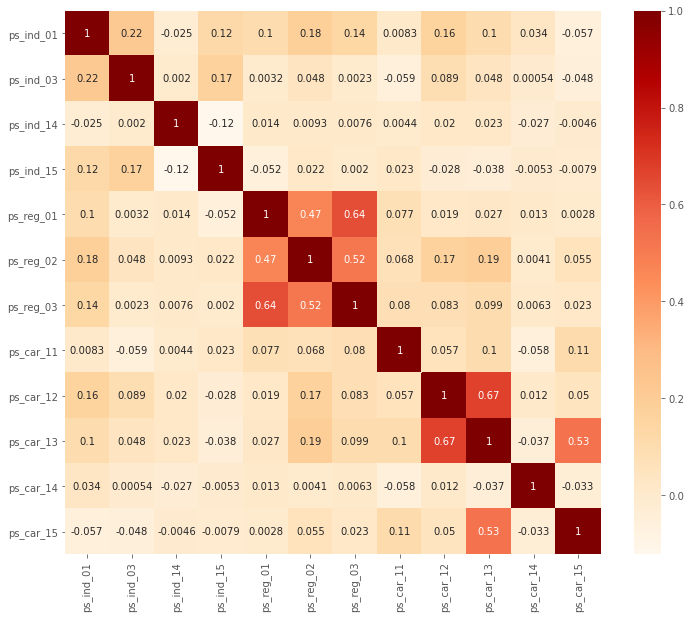

In [21]:
numerical_features = meta[(meta.level == 'numerical')].index

plt.figure(figsize=(12, 10))
cont_corr = train_df[numerical_features].corr() # Correlation between continuous features
sns.heatmap(cont_corr, annot=True, cmap='OrRd'); # Plot heatmap

There are a strong correlations between the variables:

- ps_car_12 and ps_car_13 (0.67)
- ps_reg_01 and ps_reg_03 (0.64)
- ps_reg_02 and ps_reg_03 (0.52)

Heatmap showed low number of correlated variables, we'll look at each of the highly correlated variables separately.

In [22]:
# Convert -1 from training data copy to np.NaN
train_copy = train_df.copy().replace(-1, np.NaN)
train_copy = train_copy.dropna()
s = train_copy.sample(frac=0.1)

__NOTE__: sampling was applied to speed up the process.

### ps_car_12 x ps_car_13

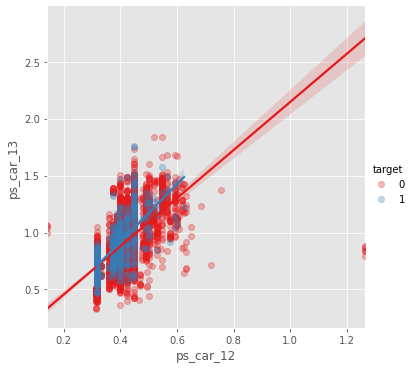

In [23]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### ps_reg_01 x ps_reg_03

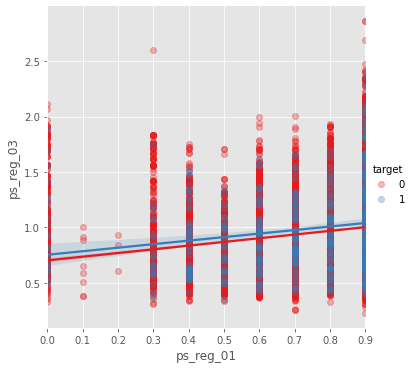

In [24]:
sns.lmplot(x='ps_reg_01', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### ps_reg_02 x ps_reg_03

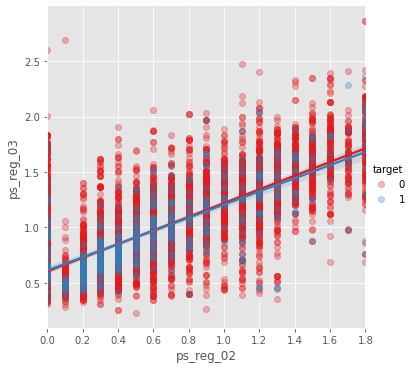

In [25]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

As the number of correlated variables is rather low, dimensionality reduction will not be applied and the model will do the heavy-lifting.

## Binary features

__Distribution__ of binary data and the __corresponding__ values of __target__ variable.

<Figure size 432x288 with 0 Axes>

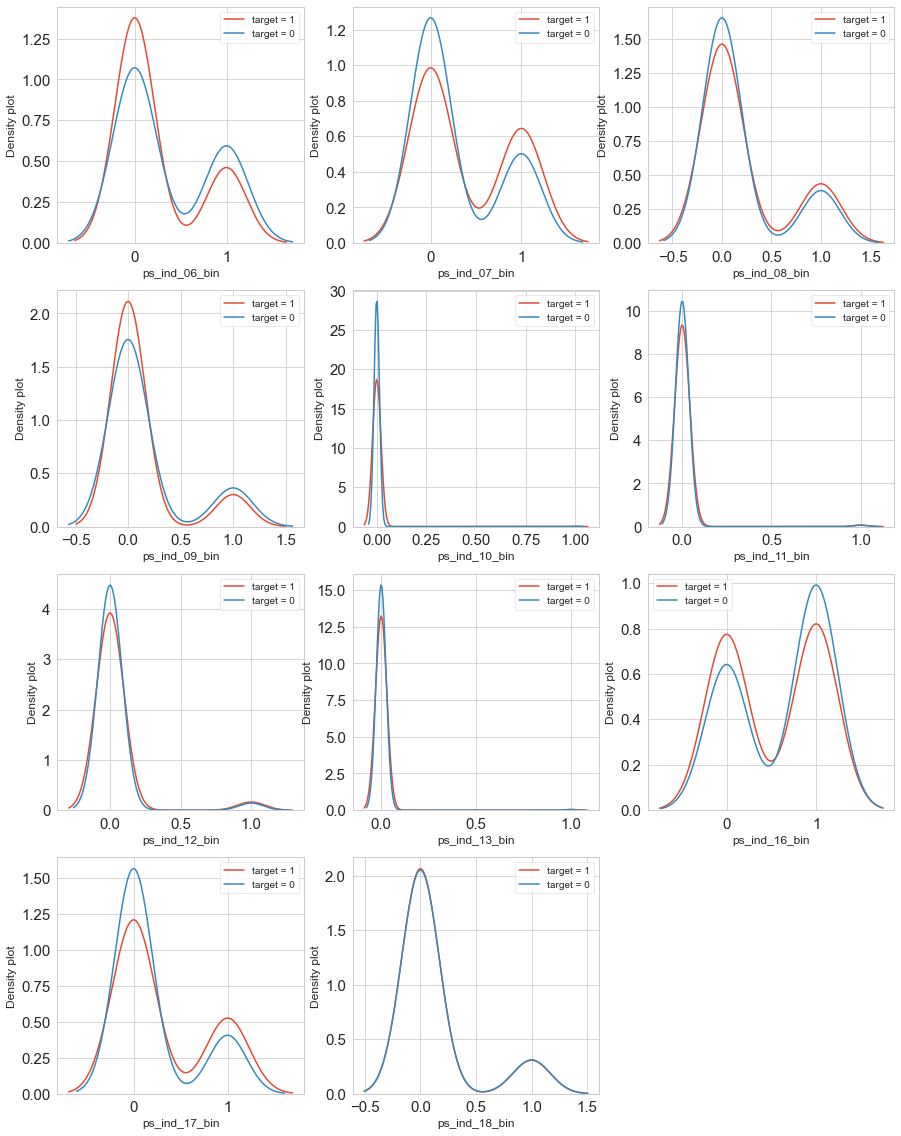

In [64]:
var = [col for col in train_copy.columns if '_bin' in col]
i = 0

s_bin = train_copy.sample(frac=0.1)
t1 = s_bin.loc[s_bin['target'] != 0]
t0 = s_bin.loc[s_bin['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(figsize=(15,20))

for feature in var:
    i += 1
    plt.subplot(4,3,i)
    sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
    plt.legend(loc='best')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

---
---
---
---

<a id="2.2"></a>
## Feature Importance

As the categorical variables are already numerical, there is no need to apply LabelEncoding.

__Reference__:
>Raschka, S., & Mirjalili, V. (2019). Python Machine Learning. Zaltbommel, Netherlands: Van Haren Publishing.

In [44]:
# Feature scaling
numerical_features = meta[(meta.level == 'numerical')].index
features_n = numerical_features.to_list()
training_normalized = train_df.copy()

features = training_normalized[features_n]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

training_normalized[features_n] = features

In [45]:
training_data = training_normalized.copy()

In [53]:
lgb_params = {
        'is_unbalance': True, # because training data is extremely unbalanced
        'objective': 'binary',
        'boosting_type': 'dart',
        'learning_rate': 0.01,
        'n_estimators': 250,
        'n_jobs': 2, # number of parallel threads
        'importance_type': 'gain'
    }
features_classifier = lgb.LGBMClassifier()
features_classifier.set_params(**lgb_params)

LGBMClassifier(boosting_type='dart', importance_type='gain', is_unbalance=True,
               learning_rate=0.01, n_estimators=250, n_jobs=2,
               objective='binary')

__StratifiedKFold__: This method should be used in situations when we have a very unbalanced class.

- __'objective': 'binary'__ is because it is a classification problem

- __'learning_rate'__ Step size shrinkage used in update to prevents overfitting. After each boosting step, we can diresctly get the weights of new features. Learning rate shrinks the feature weights to make the boosting process more conservative.

- __'boosting_type'__ gbdt suffers from over-specialization, which means trees added at later iterations tend to impact the prediction of only a few instances and make a negligible contribution towards the remaining instances. Adding dropout makes it more difficult for the trees at later iterations to specialize on those few samples and hence improves the performance. For this reason I am using __DART (Dropouts meet Multiple Additive Regression Trees)__ as boosting type.

>Rashmi, K. V., & Gilad-Bachrach, R. (2015). DART: Dropouts meet Multiple Additive Regression Trees. ArXiv.

- __'n_estimators__ Number of boosted trees to fit.
- __'n_jobs': 2__ for the best speed, set this to the number of real CPU cores, not the number of threads.
- __'importance_type': 'gain'__ result contains total gains of splits which use the feature.


In [54]:
y = training_data.target
X = training_data.drop(['target'], inplace=False, axis=1)

X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2)

In [55]:
kf = StratifiedKFold(n_splits=5, shuffle=True)
predicts = []

for train_index, test_index in kf.split(X, y):
    print('-'*70)
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    features_classifier.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50, eval_metric=["auc", "binary"])
    predicts.append(features_classifier.predict(X_test))

----------------------------------------------------------------------
[50]	valid_0's auc: 0.625756	valid_0's binary_logloss: 0.267531
[100]	valid_0's auc: 0.623423	valid_0's binary_logloss: 0.453469
[150]	valid_0's auc: 0.622388	valid_0's binary_logloss: 0.548823
[200]	valid_0's auc: 0.622499	valid_0's binary_logloss: 0.603728
[250]	valid_0's auc: 0.623025	valid_0's binary_logloss: 0.631585
----------------------------------------------------------------------
[50]	valid_0's auc: 0.626811	valid_0's binary_logloss: 0.267679
[100]	valid_0's auc: 0.626905	valid_0's binary_logloss: 0.453707
[150]	valid_0's auc: 0.626326	valid_0's binary_logloss: 0.549047
[200]	valid_0's auc: 0.626326	valid_0's binary_logloss: 0.603956
[250]	valid_0's auc: 0.626611	valid_0's binary_logloss: 0.631851
----------------------------------------------------------------------
[50]	valid_0's auc: 0.637421	valid_0's binary_logloss: 0.267607
[100]	valid_0's auc: 0.636357	valid_0's binary_logloss: 0.453775
[150]	vali

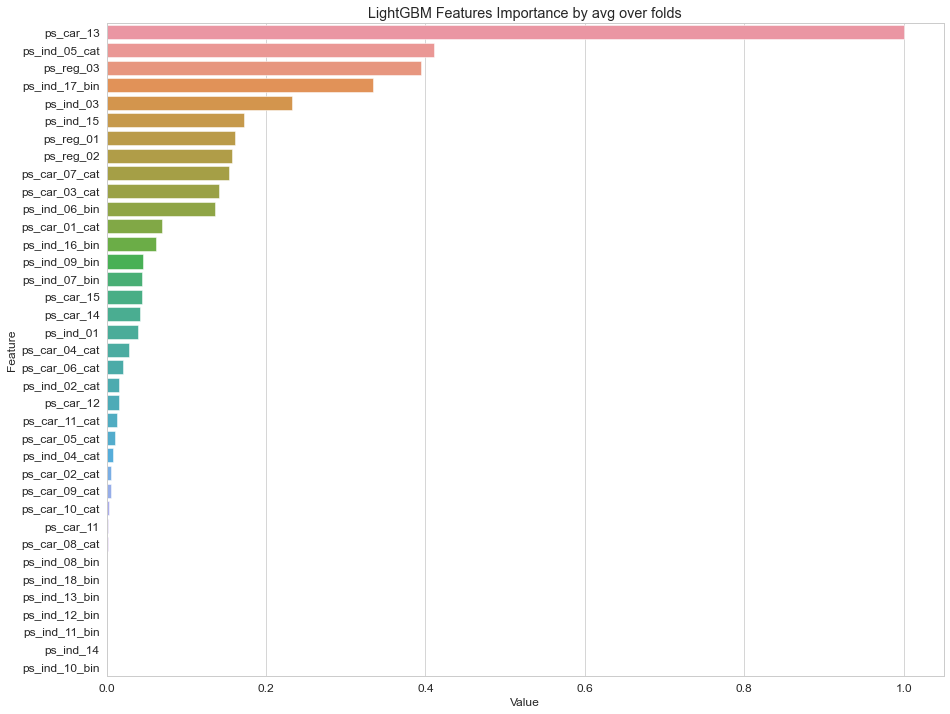

In [84]:
#Plotting features importance

feature_imp = pd.DataFrame(sorted(zip(features_classifier.feature_importances_,X.columns)), columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1))

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance by avg over folds')
plt.savefig('./plots/lgbm_importances-01.png', dpi=fig.dpi)
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

## Combining train and test data

Now that we have the Feature Importance, let's concat the train and test data in order to perform transformation on both.

In [85]:
all_data = pd.concat([train_df, test_df], ignore_index=True)
all_data = all_data.drop('target', axis=1) # Remove target value

## Dropping less important features

__SelectFromModel__ - Meta-transformer for selecting features based on importance weights.

With the get_support method we can then limit the number of variables in the train data.

>https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

In [104]:
#sfm = SelectFromModel(model, threshold='median', prefit=True)
# threshold = 100

feat_labels = all_data.columns

sfm = SelectFromModel(features_classifier, threshold='0.05*mean', prefit=True)
print('Number of features before selection: {}'.format(all_data.shape[1]))
n_features = sfm.transform(all_data).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 37
Number of features after selection: 27


In [105]:
all_data_feat_sel = all_data[selected_vars]

<a id="2.2"></a>
## Feature scaling using StandardScaler

In [145]:
features_n = [col for col in all_data_feat_sel.columns if ('_cat' not in col and '_bin' not in col)]
all_data_n = all_data_feat_sel.copy()

features = all_data_n[features_n]

# using default 
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

all_data_n[features_n] = features

<a id="2.3"></a>
## One-hot encoding categorical features

In [153]:
all_data_enc = all_data_n.copy()
categoricals_features = [col for col in all_data_feat_sel.columns if '_cat' in col]

print('Before dummification we have {} variables in train'.format(all_data_enc.shape[1]))
all_data_enc = pd.get_dummies(all_data_enc, columns=categoricals_features, drop_first=True)
print('After dummification we have {} variables in train'.format(all_data_enc.shape[1]))

Before dummification we have 27 variables in train
After dummification we have 182 variables in train


<a id="3"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">3- Models</p>

For this project I will use 2 Ensemble ML models: `LightGBM` and `XGBoost`

## Split train and test data 

In [155]:
num_train = train_df.shape[0] # Number of train data 
final_data = all_data_enc.copy()

# Divide train data and test data
X = np.asarray(final_data[:num_train])
X_test = np.asarray(final_data[num_train:])

y = np.asarray(train_df['target'])

## Evaluation Metrics

In [156]:
def eval_gini(y_true, y_pred):
    # Verify that the actual and predicted values are the same size (different values raise errors)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0] # Number of data
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # Diagonal value

    # 1) Gini coefficient for predicted values
    pred_order = y_true[y_pred.argsort()] # Sort y_true values by y_pred size
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # Lorentz Curve
    G_pred = np.sum(L_mid - L_pred) # Gini coefficient for predicted values

    # 2) Gini coefficient when prediction is perfect
    true_order = y_true[y_true.argsort()] # Sort y_true values by y_true size
    L_true = np.cumsum(true_order) / np.sum(true_order) # Lorentz Curve
    G_true = np.sum(L_mid - L_true) #  Gini coefficient when prediction is perfect

    # Normalized Gini coefficient
    return G_pred / G_true

In [157]:
def gini_lgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True

## LightGBM

In [158]:
model_lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'feature_fraction': 0.7,
        'max_bin': 255,
        'min_data_in_leaf': 1500,
        'lambda_l1': 1,
        'lambda_l2': 1,
        'bagging_freq': 1,
        'bagging_fraction': 0.7,
        'learning_rate': 0.01,
        'num_leaves': 30
    }

In [159]:
# One-dimensional array of probabilities for predicting validation data target values with an OOF-trained model
oof_val_preds_lgb = np.zeros(X.shape[0]) 
# One-dimensional array of probabilities for predicting test data target values with an OOF-trained model
oof_test_preds_lgb = np.zeros(X_test.shape[0])

# Create Stratified K Fold Cross-Verifier
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

# Train, validate, and predict models by OOF
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # The phrase that separates each fold.
    print('#'*40, f'Fold {idx+1} out of {folds.n_splits}', '#'*40)
    
    # Set train data, valid data
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_valid, y_valid = X[valid_idx], y[valid_idx] # Valid data

    # Create lgbm dataset
    dtrain = lgb.Dataset(X_train, y_train) # lgbm train dataset
    dvalid = lgb.Dataset(X_valid, y_valid) # lgbm valid dataset

    # Train LightGBM
    lgb_model = lgb.train(params=model_lgb_params, # Optimal Hyper-parameters
                           train_set=dtrain, # Train data
                           num_boost_round=1500, # Number of boosting iterations
                           valid_sets=dvalid, # Valid data for model performance evaluation
                           feval=gini_lgb, # Evaluation metrics for validation
                           early_stopping_rounds=200, # Early stopping condition
                           verbose_eval=100)
    
    # The number of boosting iterations when the model performs best 
    best_iter = lgb_model.best_iteration
    # Predict probabilities using test data
    oof_test_preds_lgb += lgb_model.predict(X_test, 
                                    num_iteration=best_iter)/folds.n_splits
    # OOF prediction for model performance evaluation
    oof_val_preds_lgb[valid_idx] += lgb_model.predict(X_valid, num_iteration=best_iter)
    
    # Normalized Gini coefficient for oof prediction probabilities
    gini_score = eval_gini(y_valid, oof_val_preds_lgb[valid_idx])
    print(f'Fold {idx+1} gini score: {gini_score}\n')

######################################## Fold 1 out of 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1263
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.153311	valid_0's gini: 0.269127
[200]	valid_0's binary_logloss: 0.152344	valid_0's gini: 0.280401
[300]	valid_0's binary_logloss: 0.151918	valid_0's gini: 0.286672
[400]	valid_0's binary_logloss: 0.151706	valid_0's gini: 0.29039
[500]	valid_0

Fold 5 gini score: 0.2942881672962029



In [160]:
print('LightGBM OOF Gini Score:', eval_gini(y, oof_val_preds_lgb))

LightGBM OOF Gini Score: 0.2881126667439246


## Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
# Fazendo previsões
y_pred = lgb_model.predict(X_test)

In [ ]:
# Acurácia
print("Acurácia em Teste:", accuracy_score(y_test, y_pred))

## Tuning the hyper-parameters

- Random Search for Hyper-Parameter Optimization
- Grid search
- Bayesian optimization

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Definição dos parâmetros
param_dist = {"": [1, 3, 7, 8, 12, None],
              "max_features": [8, 9, 10, 11, 16, 22],
              "min_samples_split": [8, 10, 11, 14, 16, 19],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7],
              "bootstrap": [True, False]}

<a id="4"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">4- Evaluation</p>

## Normalized Gini coefficient

$$ 
Gini = 2 * AUC - 1
$$

As for why use this instead of the commonly used AUC, the only reason I can think of is that a random prediction will yield a Gini score of 0 as opposed to the AUC which will be 0.5.

Besides that using the gini coefficient sets the performance of a random classifier to a score of 0... the normalization "improves" the other end of the scale and makes that the score of a perfect classifier is equal to 1 rather than a maximum achievable AUC<1. The improvement being only relative depending on whether you think a more intuitive scale is good or not. Although beyond this easier interpretation you might argue that it (the normalization) also improves generalization and comparison of different data-sets.

__Reference:__

> Hand, D. J., & Till, R. J. (2001). A Simple Generalisation of the Area Under the ROC Curve for Multiple Class Classification Problems. Machine Learning, 45(2), 171–186. https://doi.org/10.1023/a:1010920819831

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, roc_auc_score

In [ ]:
def eval_gini(y_true, y_pred):
    # Verify that the actual and predicted values are the same size (different values raise errors)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0] # Number of data
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # Diagonal value

    # 1) Gini coefficient for predicted values
    pred_order = y_true[y_pred.argsort()] # Sort y_true values by y_pred size
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # Lorentz Curve
    G_pred = np.sum(L_mid - L_pred) # Gini coefficient for predicted values

    # 2) Gini coefficient when prediction is perfect
    true_order = y_true[y_true.argsort()] # Sort y_true values by y_true size
    L_true = np.cumsum(true_order) / np.sum(true_order) # Lorentz Curve
    G_true = np.sum(L_mid - L_true) #  Gini coefficient when prediction is perfect

    # Normalized Gini coefficient
    return G_pred / G_true

In [ ]:
def gini_lgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True

In [ ]:
def gini_normalized(y_actual, y_pred):
    """Simple normalized Gini based on Scikit-Learn's roc_auc_score"""
    gini = lambda a, p: 2 * roc_auc_score(a, p) - 1
    return gini(y_actual, y_pred) / gini(y_actual, y_actual)

It turned out that the culprit was how Scikit-Learn scored the hold-out set. By default, it predicts using the predict method on the model rather than the predict_proba method. The output from predict on a classification problem is the class labels while the output from predict_proba is the probabilities for the class labels. For computing the Gini value on the results, the output of predict_proba is more appropriate.

To ensure this happens, we modify the `gini_normalized` function to allow that.

In [ ]:
def gini_normalized(y_actual, y_pred):
    """Simple normalized Gini based on Scikit-Learn's roc_auc_score"""
    
    # If the predictions y_pred are binary class probabilities
    if y_pred.ndim == 2:
        if y_pred.shape[1] == 2:
            y_pred = y_pred[:, 1]
    gini = lambda a, p: 2 * roc_auc_score(a, p) - 1
    return gini(y_actual, y_pred) / gini(y_actual, y_actual)

<a id="5"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">5- Kaggle Submission</p>

In [161]:
submission = pd.read_csv(local_path + 'sample_submission.csv', index_col='id')
submission['target'] = oof_test_preds_lgb
submission.to_csv('./ignore-folder/submission.csv')

## Score

<img src='./ignore-folder/score/scores.png' style='height:800px; border-radius: 5px;'/>

<img src='./ignore-folder/score/private_leaderboard.png' style='height:600px; border-radius: 5px;'/>